# Deep Learning- Assignment

## Import Libraries

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as ft

In [3]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam , SGD
# from keras.optimizers import Adam
# from keras.preprocessing.image import ImageDataGenerator, array_to_img,img_to_array, load_img
from tensorflow.keras.utils import array_to_img,img_to_array, load_img

## Reading and Understanding the Data

In [4]:
# Define paths for original images annotated images which are stored in different directories.
# Set some parameters
im_width = 128
im_height = 128
border = 5
path = r'C:\Users\I552991\Desktop\ML & AI\Neural Network\assignment_dataset\train\image'

In [5]:
# list of names all images in the given path
ids = next(os.walk(path))[2] 
print("No. of images = ", len(ids))

No. of images =  30


## Converted both Original and Annotated images to png format

In [6]:
 print(ids)

['11.png', '13.png', '15.png', '16.png', '17.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '35.png', '38.png', '39.png', '41.png', '43.png', '44.png', '45.png', '46.png', '47.png', '5.png', '7.png', '8.png']


In [7]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

## Convert these images into grayscale images and resize to 128 * 128 pixel images

In [8]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("C:/Users/I552991/Desktop/ML & AI/Neural Network/assignment_dataset/train/image/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load label
    lab = load_img("C:/Users/I552991/Desktop/ML & AI/Neural Network/assignment_dataset/train/label/"+id_, grayscale=True)
    mask = img_to_array(lab)
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

  0%|          | 0/30 [00:00<?, ?it/s]

In [9]:
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [10]:
print(X_train.shape)

(27, 128, 128, 1)


In [11]:
print(y_test.shape)

(3, 128, 128, 1)


In [12]:
# Open random image from the directory
# from PIL import Image
# image1 = Image.open(r'C:/Users/I552991/Desktop/ML & AI/Neural Network/assignment_dataset/train/image/39.png')
# image1.show()

In [13]:
# image2 = Image.open(r'C:/Users/I552991/Desktop/ML & AI/Neural Network/assignment_dataset/train/label/39.png')
# image2.show()

Text(0.5, 1.0, 'Power Cables')

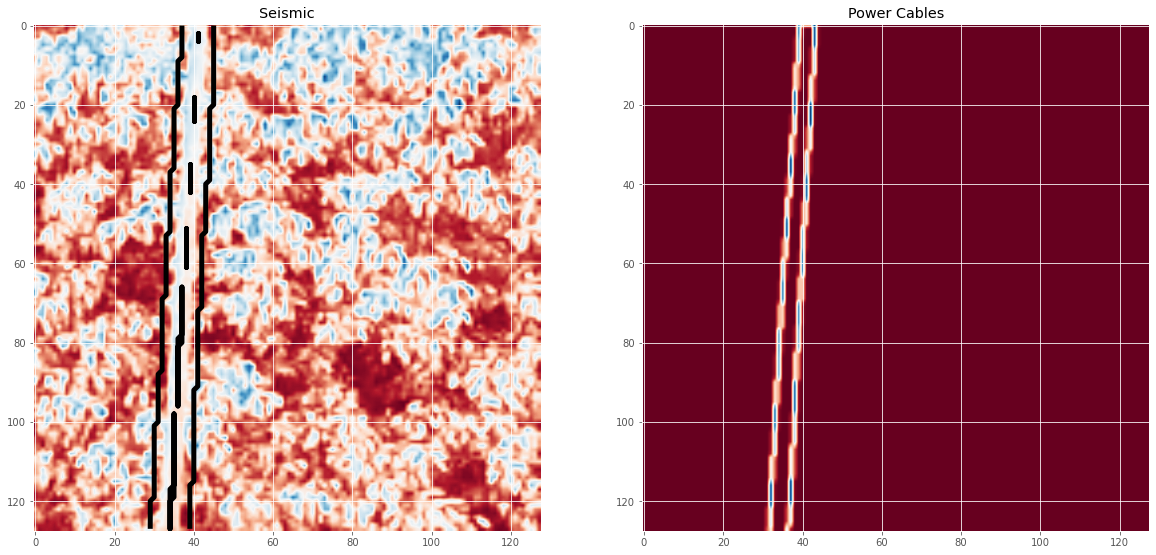

In [14]:
 # Visualize any random image along with the label
ix = random.randint(0, len(X_train))
has_label = y_train[ix].max() > 0 # Power cable indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'RdBu', interpolation = 'bilinear')
if has_label:
    # draw a boundary(contour) in the original image showing power cables
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')
#'gray'
#'Greens'
ax2.imshow(y_train[ix].squeeze(), cmap = 'RdBu', interpolation = 'bilinear')
ax2.set_title('Power Cables')


In [15]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
               kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
               kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [16]:
 def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
        """Function to define the UNET Model"""
        # Contracting Path
        c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
        p1 = MaxPooling2D((2, 2))(c1)
        p1 = Dropout(dropout)(p1)
        
        c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
        p2 = MaxPooling2D((2, 2))(c2)
        p2 = Dropout(dropout)(p2)
        
        c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
        p3 = MaxPooling2D((2, 2))(c3)
        p3 = Dropout(dropout)(p3)
        
        c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
        p4 = MaxPooling2D((2, 2))(c4)
        p4 = Dropout(dropout)(p4)
        
        c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
        # Expansive Path
        u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
        u6 = concatenate([u6, c4])
        u6 = Dropout(dropout)(u6)
        
        c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
        u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
        u7 = concatenate([u7, c3])
        u7 = Dropout(dropout)(u7)
        
        c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
        u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
        u8 = concatenate([u8, c2])
        u8 = Dropout(dropout)(u8)
        
        c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
        u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
        u9 = concatenate([u9, c1])
        u9 = Dropout(dropout)(u9)
        
        c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
        outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
        model = Model(inputs=[input_img], outputs=[outputs])
        return model

## Create Model

In [17]:
# Compile the model. 
# Use Adam optimizer, with ‘binary_crossentropy‘ and use Accuracy as the metric.
# Use Adam optimizer with default learning as 0.001
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [18]:
# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 128, 128, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

## Model Training

In [19]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-powerline.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [21]:
# Train the model using a batch size of 10. Train for 1000 epochs
results = model.fit(X_train, y_train, batch_size=10, epochs=1000, callbacks=callbacks,\
validation_data=(X_test, y_test))

Epoch 1/1000
3/3 [==============================] - ETA: 0s - loss: 0.8848 - accuracy: 0.2864
Epoch 1: val_loss improved from inf to 0.71518, saving model to model-tgs-powerline.h5
3/3 [==============================] - 17s 2s/step - loss: 0.8848 - accuracy: 0.2864 - val_loss: 0.7152 - val_accuracy: 0.3426 - lr: 0.0010
Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 0.8242 - accuracy: 0.3216
Epoch 2: val_loss did not improve from 0.71518
3/3 [==============================] - 3s 915ms/step - loss: 0.8242 - accuracy: 0.3216 - val_loss: 0.7461 - val_accuracy: 0.3287 - lr: 0.0010
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 0.7695 - accuracy: 0.3667
Epoch 3: val_loss did not improve from 0.71518
3/3 [==============================] - 3s 925ms/step - loss: 0.7695 - accuracy: 0.3667 - val_loss: 0.8934 - val_accuracy: 0.3546 - lr: 0.0010
Epoch 4/1000
3/3 [==============================] - ETA: 0s - loss: 0.7149 - accuracy: 0.4348
Epoch 4: val_loss d

## Plot the Loss and Accuracy curves for both training and validation

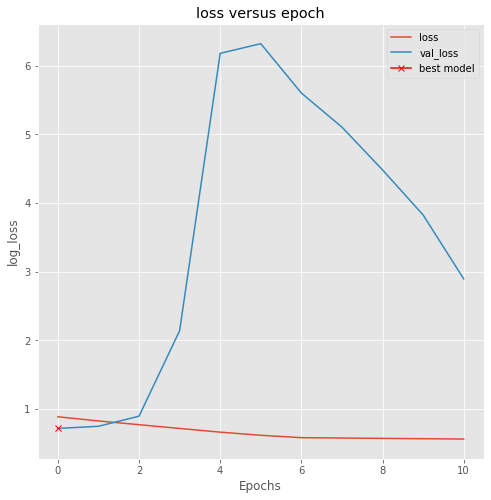

In [22]:
plt.figure(figsize=(8, 8))
plt.title("loss versus epoch")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


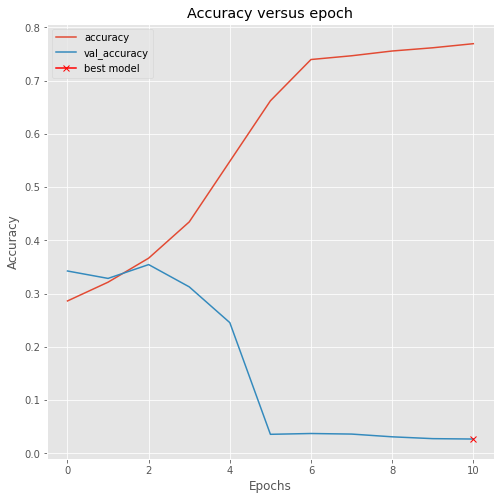

In [23]:
plt.figure(figsize=(8, 8))
plt.title("Accuracy versus epoch")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmin(results.history["val_accuracy"]), np.min(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();


## Evaluate the Model

In [24]:
 # load the best model
model.load_weights('model-tgs-powerline.h5')

In [25]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 0s 114ms/step - loss: 0.7152 - accuracy: 0.3426


[0.7151816487312317, 0.34259033203125]

In [26]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

1/1 [==============================] - 0s 126ms/step


In [27]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

##  Visualize the performance of detection

In [28]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))
    has_mask = y[ix].max() > 0
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='RdBu')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('gray')
    
    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Powerline')
    
    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Powerline Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Powerline Predicted binary');


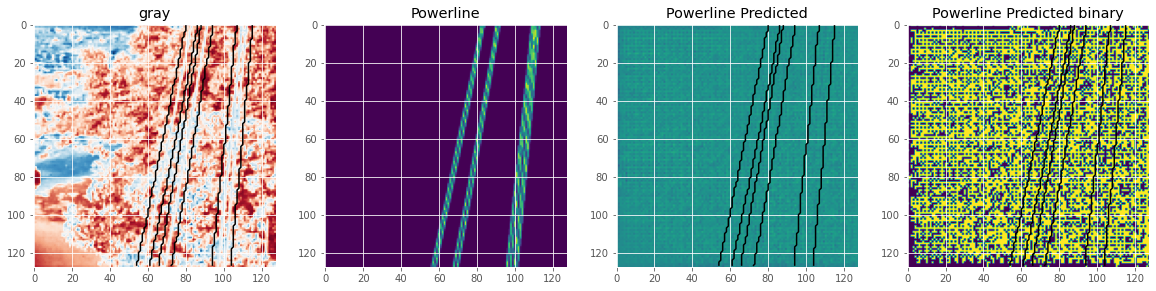

In [29]:
 # Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t)

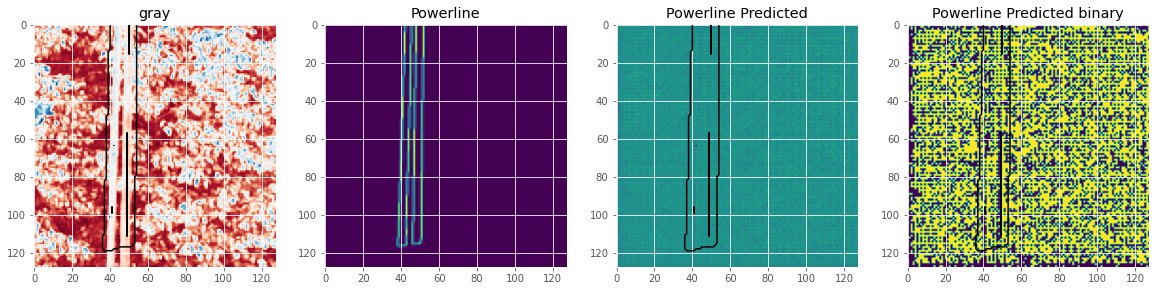

In [30]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

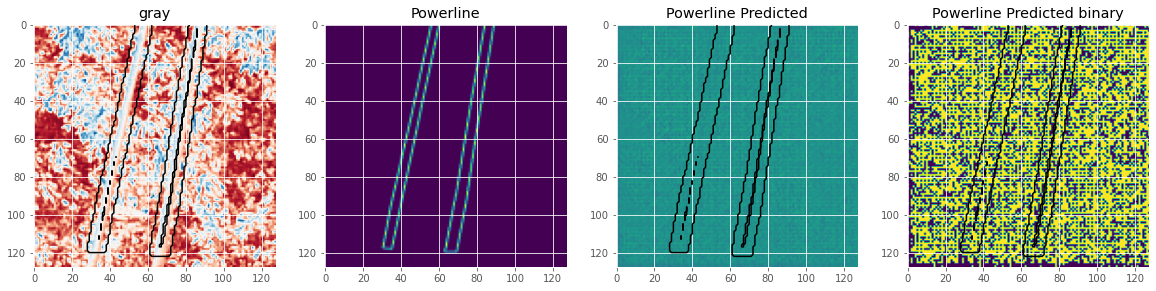

In [32]:
 # Check if valid data looks all right
plot_sample(X_test, y_test, preds_val, preds_val_t, ix=2)

# Experiments

## Experiment 1: Change the optimizer learning rate of the Adam optimizer to 1e-4

In [33]:
# Create and compile Model
# Use Adam optimizer, with ‘binary_crossentropy‘ and use Accuracy as the metric.
# Use Adam optimizer with learning rate as 0.0001

input_img = Input((im_height, im_width, 1), name='img')
model1 = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model1.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [34]:
# Model summary
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 128, 128, 16  64         ['conv2d_20[0][0]']              
 ormalization)                  )                                                           

In [36]:
# Train the model using a batch size of 10. Train for 1000 epochs
results1 = model1.fit(X_train, y_train, batch_size=10, epochs=1000, callbacks=callbacks,\
validation_data = (X_test, y_test))

Epoch 1/1000
3/3 [==============================] - ETA: 0s - loss: 1.1843 - accuracy: 0.1958
Epoch 1: val_loss did not improve from 0.71518
3/3 [==============================] - 16s 1s/step - loss: 1.1843 - accuracy: 0.1958 - val_loss: 0.8761 - val_accuracy: 0.0309 - lr: 1.0000e-04
Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 1.1709 - accuracy: 0.1774
Epoch 2: val_loss did not improve from 0.71518
3/3 [==============================] - 3s 878ms/step - loss: 1.1709 - accuracy: 0.1774 - val_loss: 0.8662 - val_accuracy: 0.0381 - lr: 1.0000e-04
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 1.1594 - accuracy: 0.1694
Epoch 3: val_loss did not improve from 0.71518
3/3 [==============================] - 3s 917ms/step - loss: 1.1594 - accuracy: 0.1694 - val_loss: 0.8548 - val_accuracy: 0.0472 - lr: 1.0000e-04
Epoch 4/1000
3/3 [==============================] - ETA: 0s - loss: 1.1481 - accuracy: 0.1570
Epoch 4: val_loss did not improve from 0.71518


## Plot the Loss and Accuracy curves for both training and validation

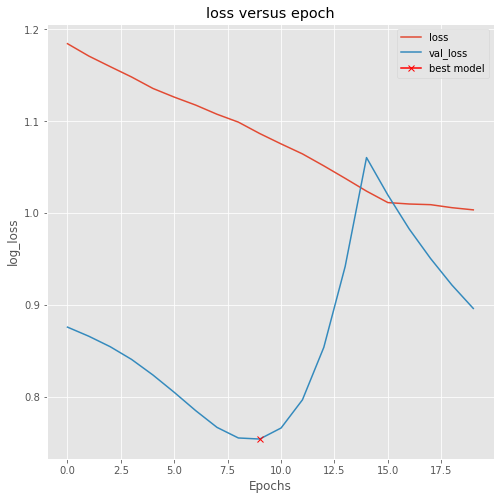

In [37]:
plt.figure(figsize=(8, 8))
plt.title("loss versus epoch")
plt.plot(results1.history["loss"], label="loss")
plt.plot(results1.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results1.history["val_loss"]), np.min(results1.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

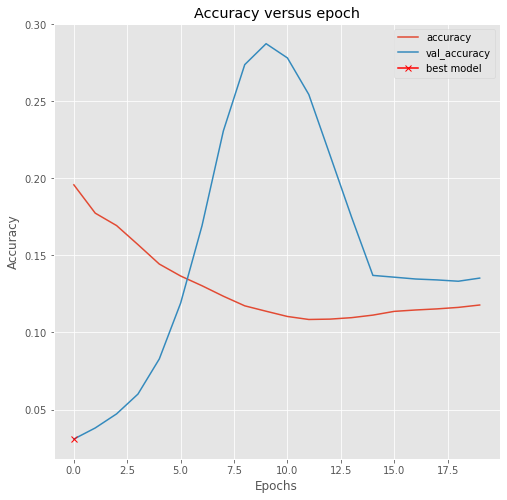

In [38]:
plt.figure(figsize=(8, 8))
plt.title("Accuracy versus epoch")
plt.plot(results1.history["accuracy"], label="accuracy")
plt.plot(results1.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmin(results1.history["val_accuracy"]), np.min(results1.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();


In [39]:
 # load the best model
model1.load_weights('model-tgs-powerline.h5')
# Evaluate on validation set (this must be equals to the best log_loss)
model1.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 0s 237ms/step - loss: 0.7152 - accuracy: 0.3426


[0.7151816487312317, 0.34259033203125]

In [40]:
# Predict on train, val and test
preds_train1 = model1.predict(X_train, verbose=1)
preds_val1 = model1.predict(X_test, verbose=1)

1/1 [==============================] - 0s 126ms/step


In [41]:
# Threshold predictions
preds_train_t1 = (preds_train1 > 0.5).astype(np.uint8)
preds_val_t1 = (preds_val1 > 0.5).astype(np.uint8)

## Visualize the performance of detection

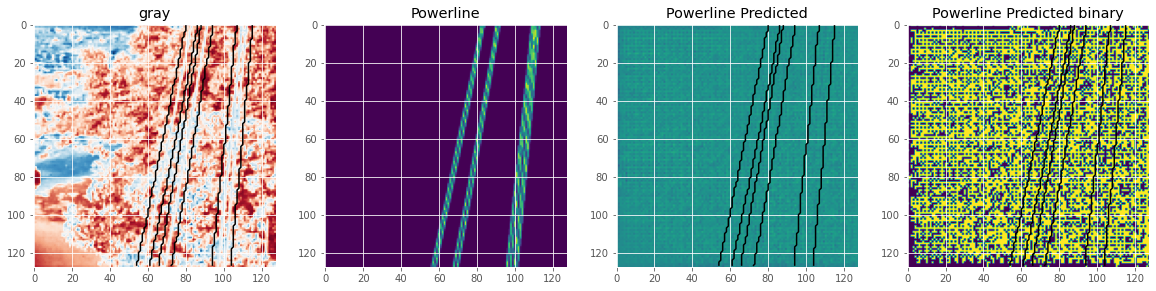

In [42]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train1, preds_train_t1, ix=15)

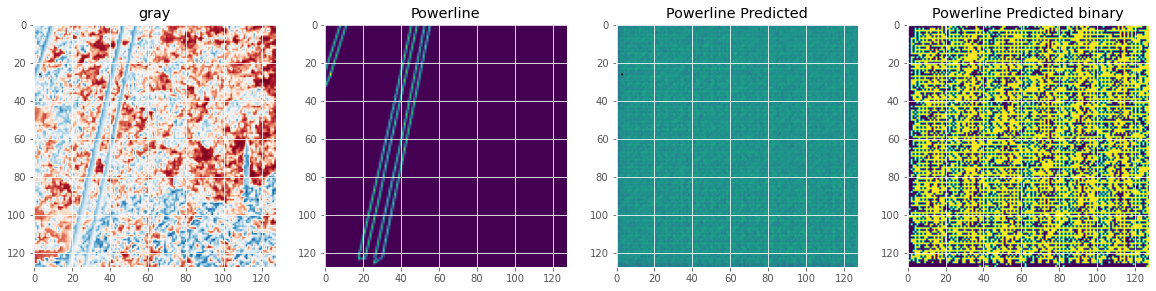

In [43]:
plot_sample(X_train, y_train, preds_train1, preds_train_t1)

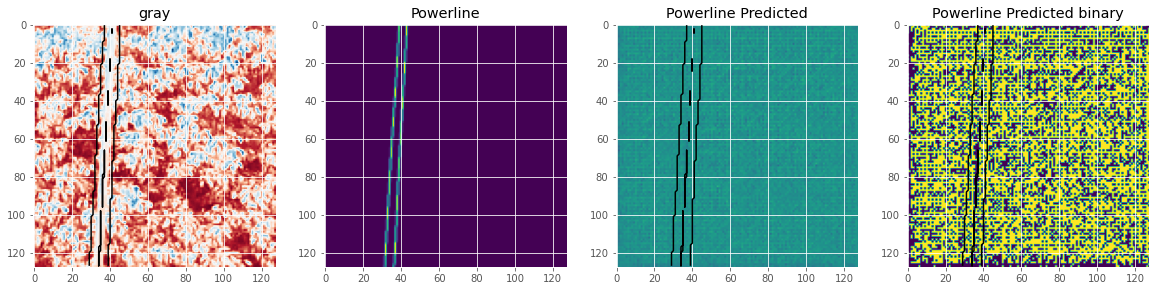

In [44]:
plot_sample(X_train, y_train, preds_train1, preds_train_t1)

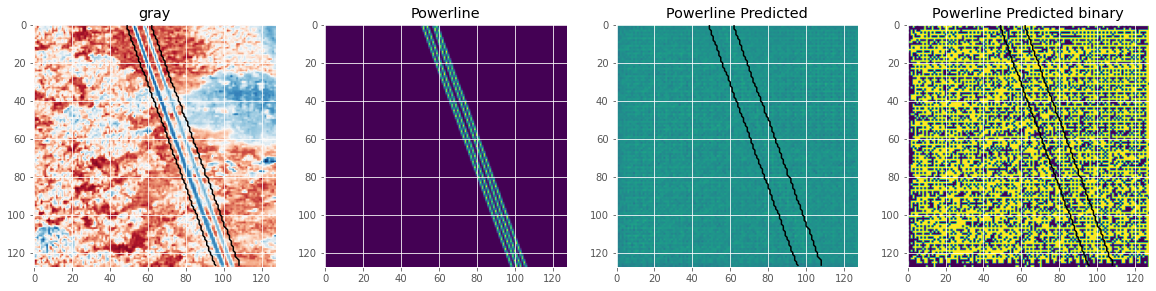

In [45]:
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_val1, preds_val_t1, ix=0)

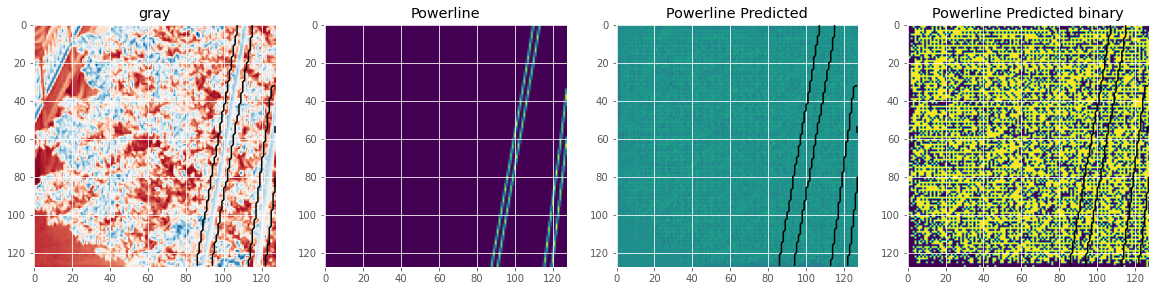

In [46]:
plot_sample(X_test, y_test, preds_val1, preds_val_t1, ix=1)

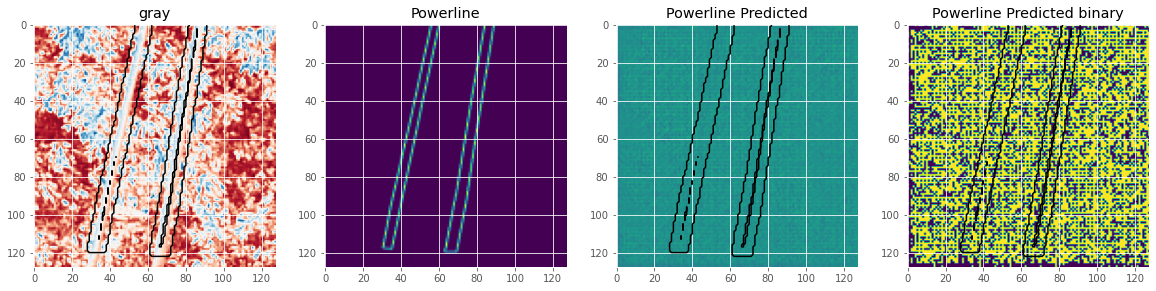

In [47]:
plot_sample(X_test, y_test, preds_val1, preds_val_t1, ix=2)

## Experiment 2: Change the optimizer to SGD

In [48]:
# Create and compile Model
# Use SGD optimizer

input_img = Input((im_height, im_width, 1), name='img')
model2 = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model2.compile(optimizer=SGD(), loss="binary_crossentropy", metrics=["accuracy"])

# Model summary
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_39 (Conv2D)             (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_37 (BatchN  (None, 128, 128, 16  64         ['conv2d_39[0][0]']              
 ormalization)                  )                                                           

In [49]:
# Train the model using a batch size of 10. Train for 1000 epochs
results2 = model2.fit(X_train, y_train, batch_size=10, epochs=1000, callbacks=callbacks,\
validation_data = (X_test, y_test))

Epoch 1/1000
3/3 [==============================] - ETA: 0s - loss: 0.4431 - accuracy: 0.7623
Epoch 1: val_loss did not improve from 0.71518
3/3 [==============================] - 14s 2s/step - loss: 0.4431 - accuracy: 0.7623 - val_loss: 0.7181 - val_accuracy: 0.3770 - lr: 0.0100
Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 0.4307 - accuracy: 0.7737
Epoch 2: val_loss improved from 0.71518 to 0.70046, saving model to model-tgs-powerline.h5
3/3 [==============================] - 4s 1s/step - loss: 0.4307 - accuracy: 0.7737 - val_loss: 0.7005 - val_accuracy: 0.4528 - lr: 0.0100
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 0.4180 - accuracy: 0.7820
Epoch 3: val_loss improved from 0.70046 to 0.68270, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 1s/step - loss: 0.4180 - accuracy: 0.7820 - val_loss: 0.6827 - val_accuracy: 0.5289 - lr: 0.0100
Epoch 4/1000
3/3 [==============================] - ETA: 0s - loss: 0.4

## Plot the Loss and Accuracy curves for both training and validation

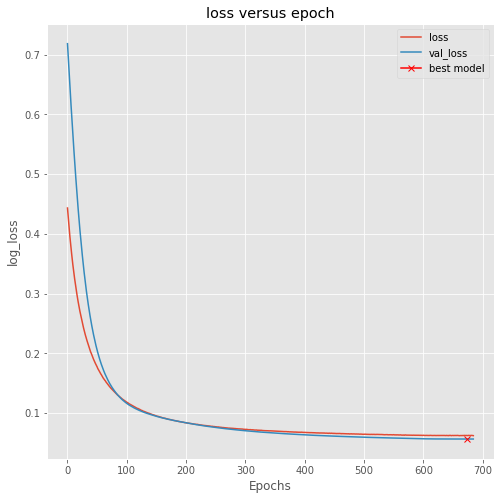

In [50]:
plt.figure(figsize=(8, 8))
plt.title("loss versus epoch")
plt.plot(results2.history["loss"], label="loss")
plt.plot(results2.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results2.history["val_loss"]), np.min(results2.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

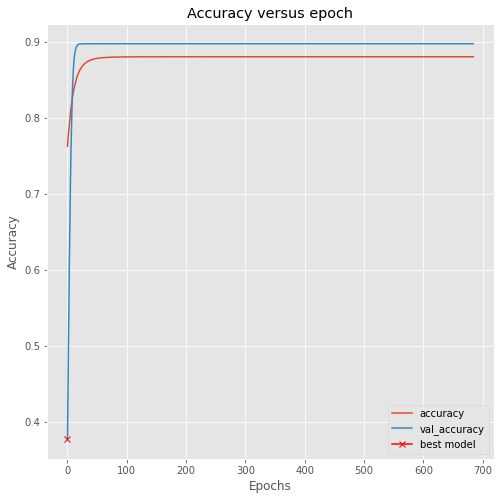

In [51]:
plt.figure(figsize=(8, 8))
plt.title("Accuracy versus epoch")
plt.plot(results2.history["accuracy"], label="accuracy")
plt.plot(results2.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmin(results2.history["val_accuracy"]), np.min(results2.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [52]:
 # load the best model
model2.load_weights('model-tgs-powerline.h5')
# Evaluate on validation set (this must be equals to the best log_loss)
model2.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 0s 65ms/step - loss: 0.0565 - accuracy: 0.8973


[0.05651344731450081, 0.89727783203125]

In [53]:
# Predict on train, val and test
preds_train2 = model2.predict(X_train, verbose=1)
preds_val2 = model2.predict(X_test, verbose=1)

1/1 [==============================] - 0s 60ms/step


In [54]:
# Threshold predictions
preds_train_t2 = (preds_train2 > 0.5).astype(np.uint8)
preds_val_t2 = (preds_val2 > 0.5).astype(np.uint8)

## Visualize the performance of detection

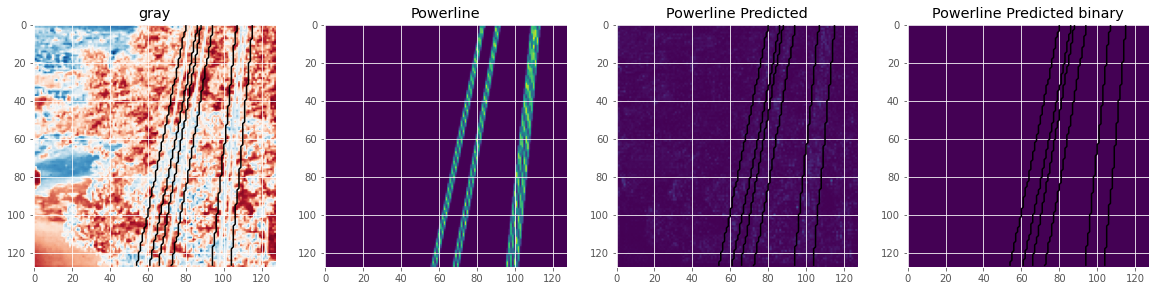

In [55]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train2, preds_train_t2, ix=15)

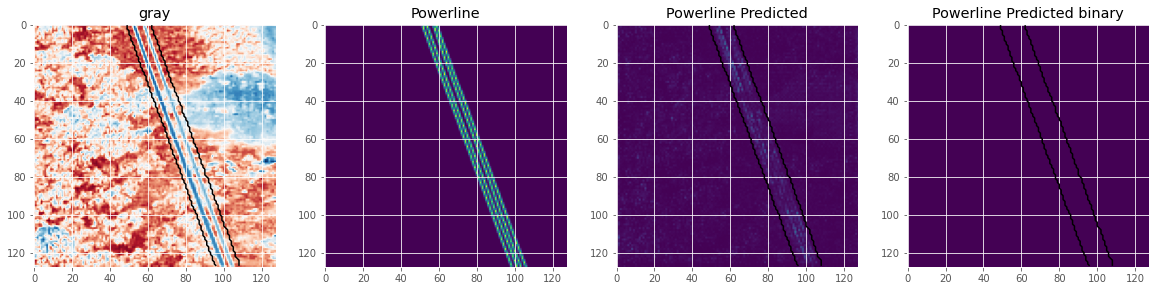

In [56]:
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_val2, preds_val_t2, ix=0)

## Experiment 3: Train the model for 100 epochs

In [57]:
# Create and compile Model
# Use SGD optimizer with 100 epochs

input_img = Input((im_height, im_width, 1), name='img')
model3 = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model3.compile(optimizer=SGD(), loss="binary_crossentropy", metrics=["accuracy"])

# Model summary
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_58 (Conv2D)             (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_55 (BatchN  (None, 128, 128, 16  64         ['conv2d_58[0][0]']              
 ormalization)                  )                                                           

In [58]:
# Train the model using a batch size of 10. Train for 100 epochs
results3 = model3.fit(X_train, y_train, batch_size=10, epochs=100, callbacks=callbacks,\
validation_data = (X_test, y_test))

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.7337 - accuracy: 0.4703
Epoch 1: val_loss did not improve from 0.05651
3/3 [==============================] - 6s 940ms/step - loss: 0.7337 - accuracy: 0.4703 - val_loss: 0.6256 - val_accuracy: 0.7630 - lr: 0.0100
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.7051 - accuracy: 0.5010
Epoch 2: val_loss did not improve from 0.05651
3/3 [==============================] - 2s 620ms/step - loss: 0.7051 - accuracy: 0.5010 - val_loss: 0.6191 - val_accuracy: 0.7964 - lr: 0.0100
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.6783 - accuracy: 0.5312
Epoch 3: val_loss did not improve from 0.05651
3/3 [==============================] - 2s 632ms/step - loss: 0.6783 - accuracy: 0.5312 - val_loss: 0.6131 - val_accuracy: 0.8214 - lr: 0.0100
Epoch 4/100
3/3 [==============================] - ETA: 0s - loss: 0.6532 - accuracy: 0.5592
Epoch 4: val_loss did not improve from 0.05651
3/3 [=========

## Plot the Loss and Accuracy curves for both training and validation

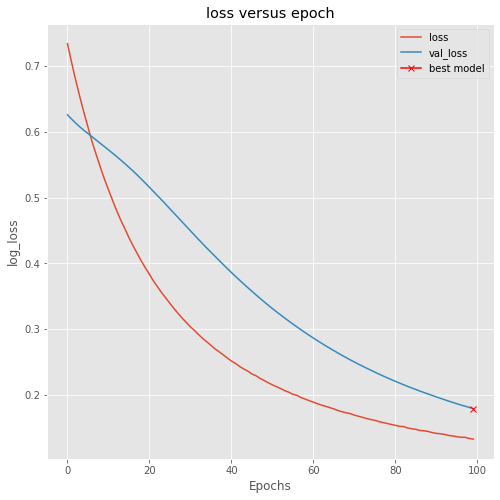

In [59]:
plt.figure(figsize=(8, 8))
plt.title("loss versus epoch")
plt.plot(results3.history["loss"], label="loss")
plt.plot(results3.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results3.history["val_loss"]), np.min(results3.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

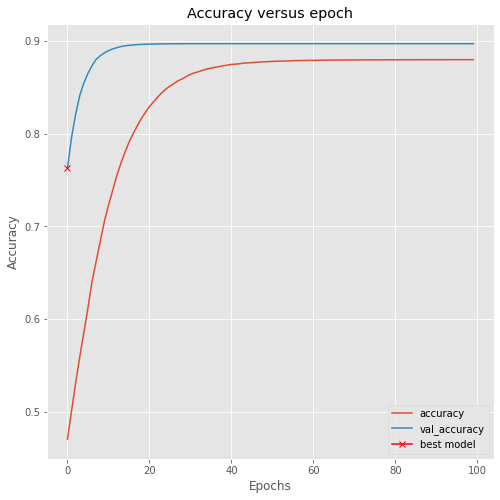

In [60]:
plt.figure(figsize=(8, 8))
plt.title("Accuracy versus epoch")
plt.plot(results3.history["accuracy"], label="accuracy")
plt.plot(results3.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmin(results3.history["val_accuracy"]), np.min(results3.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [61]:
 # load the best model
model3.load_weights('model-tgs-powerline.h5')
# Evaluate on validation set (this must be equals to the best log_loss)
model3.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 0s 77ms/step - loss: 0.0565 - accuracy: 0.8973


[0.05651344731450081, 0.89727783203125]

In [62]:
# Predict on train, val and test
preds_train3 = model3.predict(X_train, verbose=1)
preds_val3 = model3.predict(X_test, verbose=1)

1/1 [==============================] - 0s 73ms/step


In [63]:
# Threshold predictions
preds_train_t3 = (preds_train3 > 0.5).astype(np.uint8)
preds_val_t3 = (preds_val3 > 0.5).astype(np.uint8)

## Visualize the performance of detection

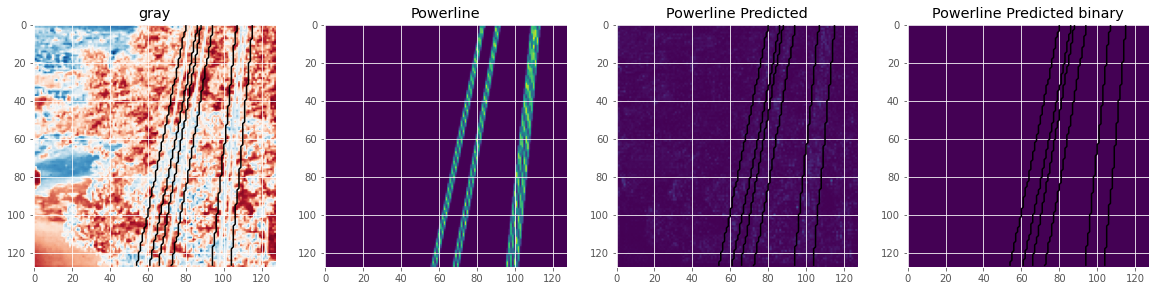

In [64]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train3, preds_train_t3, ix=15)

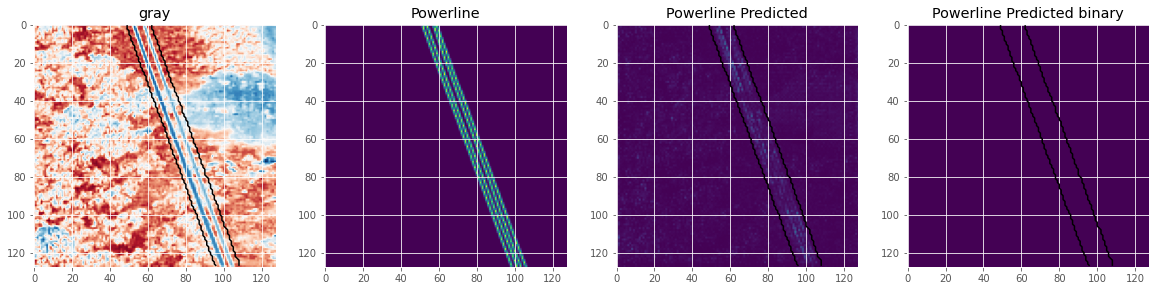

In [65]:
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_val3, preds_val_t3, ix=0)

## Experiment 4: Use threshold values of .4

In [66]:
# Threshold predictions
preds_train_t4 = (preds_train3 > 0.4).astype(np.uint8)
preds_val_t4 = (preds_val3 > 0.4).astype(np.uint8)

## Visualize the performance of detection

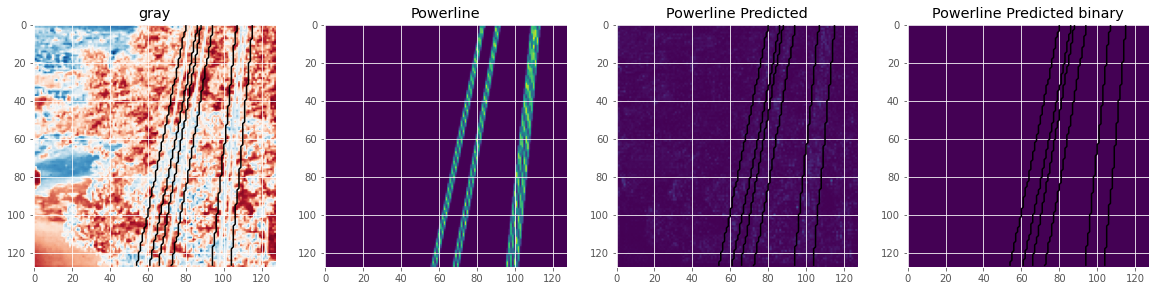

In [67]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train3, preds_train_t4, ix=15)

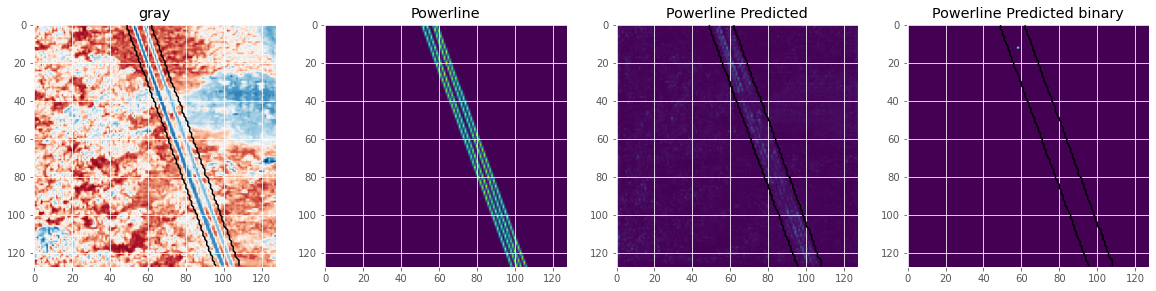

In [68]:
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_val3, preds_val_t4, ix=0)

## Experiment 5: Use threshold values of .7

In [69]:
# Threshold predictions
preds_train_t5 = (preds_train3 > 0.7).astype(np.uint8)
preds_val_t5 = (preds_val3 > 0.7).astype(np.uint8)

## Visualize the performance of detection

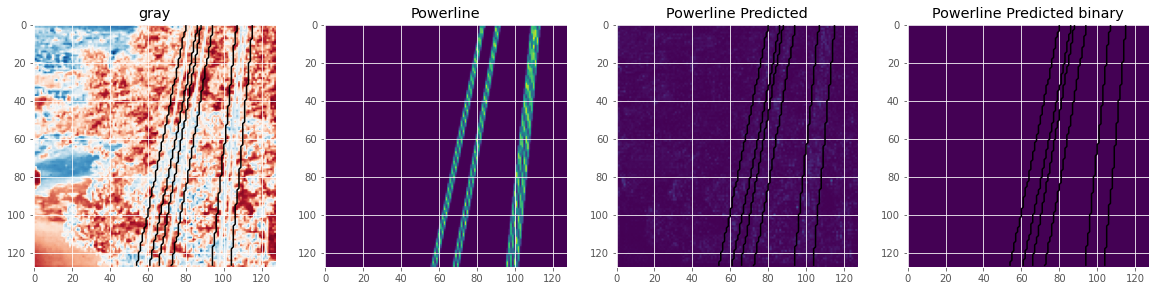

In [70]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train3, preds_train_t5, ix=15)

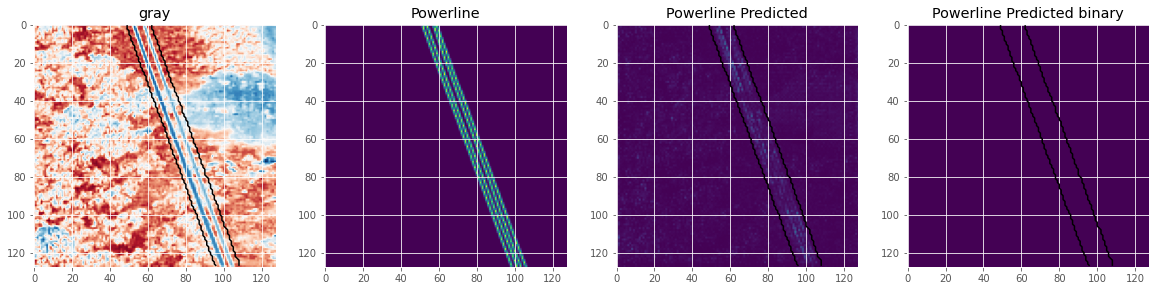

In [71]:
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_val3, preds_val_t5, ix=0)